In [1]:
import transformers
#import datasets
import numpy as np
import pandas as pd
import torch
from PIL import Image
import requests

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "mps" if torch.backends.mps.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id,cache_dir='../run/')
processor = CLIPProcessor.from_pretrained(model_id,cache_dir='../run/')
model = CLIPModel.from_pretrained(model_id,cache_dir='../run/').to(device)

In [3]:
urls=['https://images.unsplash.com/photo-1662955676669-c5d141718bfd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80',
    'https://images.unsplash.com/photo-1552053831-71594a27632d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=662&q=80',
    'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=688&q=80']

images=[Image.open(requests.get(i, stream=True).raw)  for i in urls]

In [4]:
text_prompts=["a girl wearing a beanie", "a boy wearing a beanie", "a dog", "a dog at the beach"]
inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

In [5]:
inputs={'input_ids':inputs['input_ids'].to(device),'attention_mask':inputs['attention_mask'].to(device),'pixel_values':inputs['pixel_values'].to(device)}

In [14]:
inputs['input_ids']

tensor([[49406,   320,  1611,  3309,   320, 21534, 49407],
        [49406,   320,  1876,  3309,   320, 21534, 49407],
        [49406,   320,  1929, 49407, 49407, 49407, 49407],
        [49406,   320,  1929,   536,   518,  2117, 49407]], device='cuda:0')

In [15]:
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [16]:
inputs['pixel_values']

tensor([[[[-1.2813, -1.2959, -1.2959,  ..., -1.2959, -1.2813, -1.2813],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2813, -1.2813, -1.2813],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2813, -1.2813, -1.2813],
          ...,
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959]],

         [[-1.2568, -1.2418, -1.2268,  ..., -1.2418, -1.2268, -1.2268],
          [-1.2418, -1.2418, -1.2418,  ..., -1.2268, -1.2268, -1.2268],
          [-1.2418, -1.2418, -1.2418,  ..., -1.2268, -1.2268, -1.2268],
          ...,
          [-1.2418, -1.2418, -1.2418,  ..., -1.2418, -1.2418, -1.2418],
          [-1.2418, -1.2418, -1.2418,  ..., -1.2418, -1.2418, -1.2418],
          [-1.2418, -1.2418, -1.2418,  ..., -1.2418, -1.2418, -1.2418]],

         [[-0.9967, -0.9967, -0.9967,  ..., -0.9967, -0.9825, -0.9825],
          [-0.9967, -0.9967, -

In [13]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image 
probs = logits_per_image.softmax(dim=1)
pd.DataFrame(probs.detach().cpu().numpy()*100, columns=text_prompts, index=list(['image1','image2', 'image3'])).style.background_gradient(axis=None,low=0, high=0.91).format(precision=2)

,a girl wearing a beanie,a boy wearing a beanie,a dog,a dog at the beach
image1,99.36,0.64,0.00,0.00
image2,0.65,0.58,87.59,11.18
image3,0.01,0.01,0.95,99.04


In [26]:
outputs

CLIPOutput(loss=None, logits_per_image=tensor([[28.7724, 23.7219, 17.4950, 15.3978],
        [20.8687, 20.7507, 25.7708, 23.7122],
        [19.5242, 20.0346, 24.7177, 29.3665]], device='cuda:0',
       grad_fn=<TBackward0>), logits_per_text=tensor([[28.7724, 20.8687, 19.5242],
        [23.7219, 20.7507, 20.0346],
        [17.4950, 25.7708, 24.7177],
        [15.3978, 23.7122, 29.3665]], device='cuda:0', grad_fn=<MulBackward0>), text_embeds=tensor([[ 0.0293,  0.0070, -0.0310,  ..., -0.0064, -0.0441, -0.0387],
        [ 0.0207,  0.0075, -0.0163,  ..., -0.0324, -0.0437, -0.0631],
        [ 0.0127,  0.0020, -0.0256,  ..., -0.0393, -0.0300,  0.0158],
        [ 0.0096,  0.0233, -0.0467,  ...,  0.0286, -0.0284,  0.0037]],
       device='cuda:0', grad_fn=<DivBackward0>), image_embeds=tensor([[-0.0019,  0.0320,  0.0053,  ...,  0.0271, -0.0090,  0.0065],
        [ 0.0276,  0.0074, -0.0080,  ..., -0.0272,  0.0348,  0.0008],
        [ 0.0377,  0.0439, -0.0015,  ...,  0.0148,  0.0072, -0.0144]],
  

In [18]:
probs

tensor([[9.9362e-01, 6.3653e-03, 1.2575e-05, 1.5443e-06],
        [6.5088e-03, 5.7847e-03, 8.7590e-01, 1.1180e-01],
        [5.2644e-05, 8.7698e-05, 9.4809e-03, 9.9038e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [7]:
logits_per_image

tensor([[28.7724, 23.7219, 17.4950, 15.3978],
        [20.8687, 20.7507, 25.7708, 23.7122],
        [19.5242, 20.0346, 24.7177, 29.3665]], device='cuda:0',
       grad_fn=<TBackward0>)

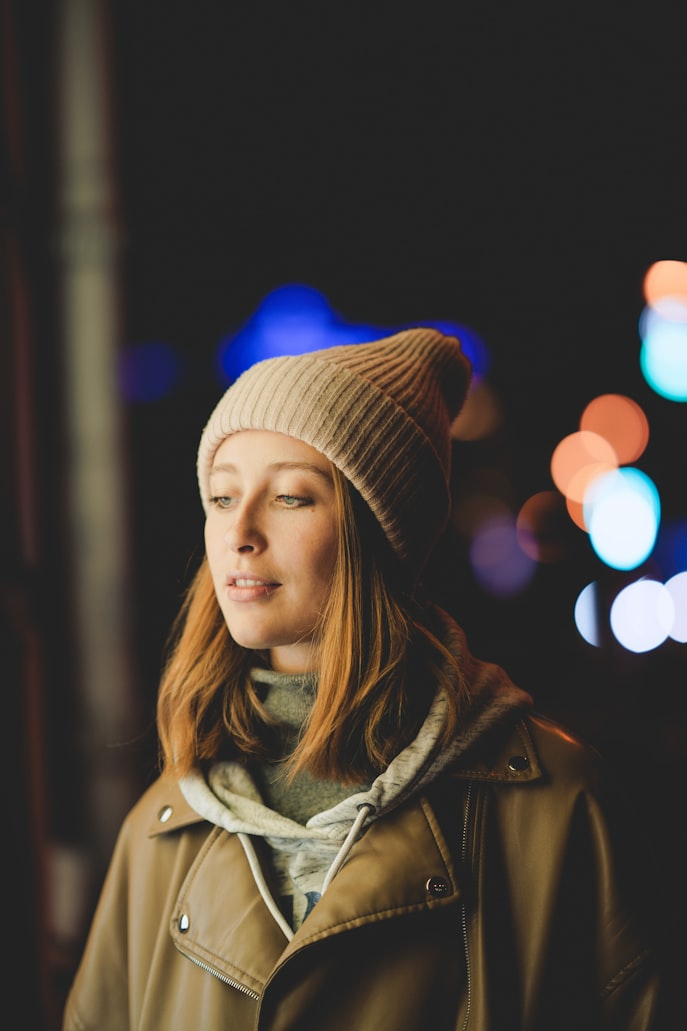

In [8]:
images[0]

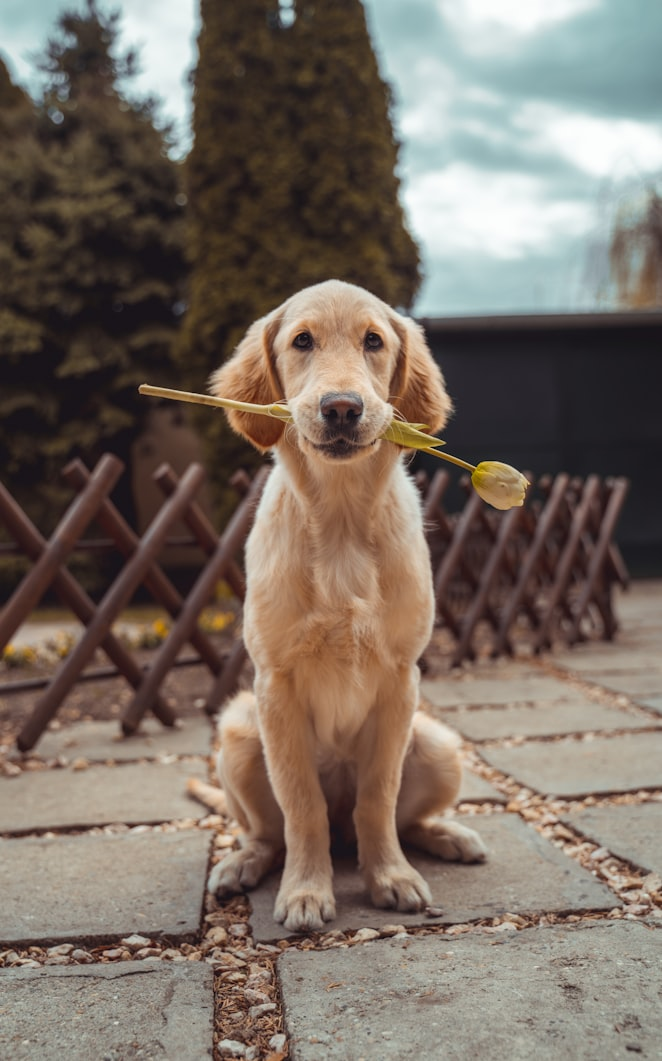

In [9]:
images[1]

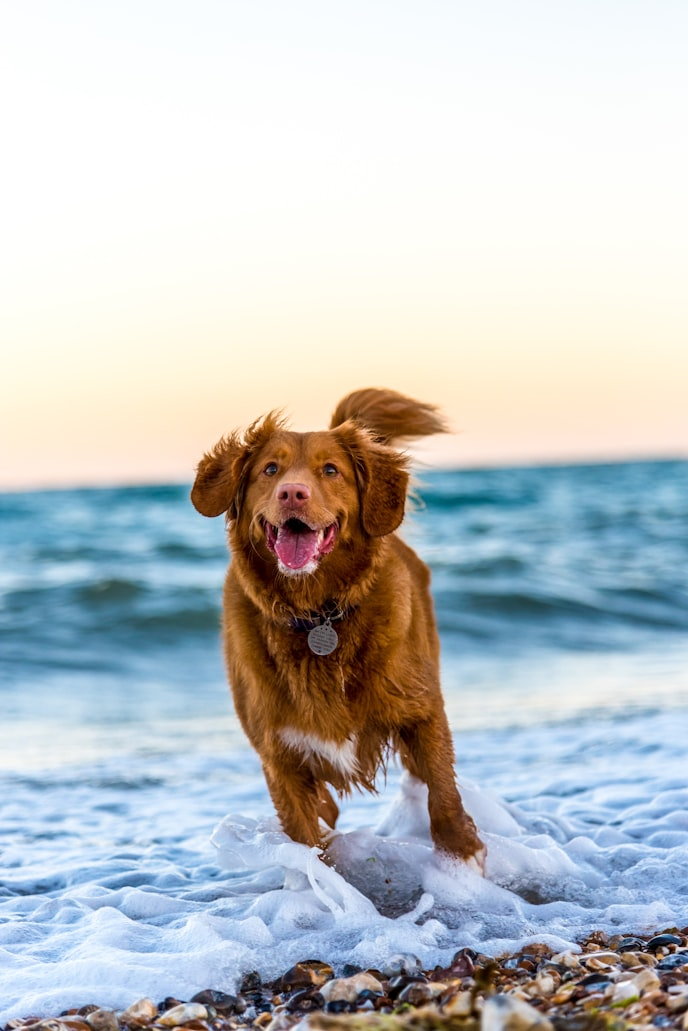

In [10]:
images[2]

In [11]:
inputs['pixel_values'].shape

torch.Size([3, 3, 224, 224])

In [23]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, l

In [27]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,